In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for BERT model and tokenization
bert_path = "bert-base-uncased"  # Use the Hugging Face model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

def get_df(file):
    return pd.read_csv(file,sep = '\t')

train_df = get_df('train_posts.txt')
test_df = get_df('test_posts.txt')

def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

tqdm.pandas()
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

from os import listdir

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3755/3755 [00:00<00:00, 87939.98it/s]


# Text part

#mBERT-base

In [2]:
import numpy as np
from transformers import BertTokenizer
from tqdm import tqdm  # Import tqdm for progress tracking
import torch

class PaddingInputExample:
    """Fake example so the num input examples is a multiple of the batch size."""
    pass  # No need for methods or properties; just a marker class

class InputExample:
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second sequence.
            label: (Optional) string. The label of the example.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer():
    """Instantiate the mBERT tokenizer."""
    return BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)

    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)

    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []

    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

    return (
        torch.tensor(input_ids),          # Use torch tensors
        torch.tensor(input_masks),        # Use torch tensors
        torch.tensor(segment_ids),        # Use torch tensors
        torch.tensor(labels).reshape(-1, 1)  # Use torch tensors
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    input_examples = []
    for text, label in zip(texts, labels):
        input_examples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return input_examples

# Instantiate the tokenizer
tokenizer = create_tokenizer()

# Convert data to InputExample format
# Assuming train_text and trainY, test_text and testY are already defined
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
train_input_ids, train_input_masks, train_segment_ids, trainY = convert_examples_to_features(tokenizer, train_examples, max_seq_length=128)
test_input_ids, test_input_masks, test_segment_ids, testY = convert_examples_to_features(tokenizer, test_examples, max_seq_length=128)

# Now you can proceed to use `train_input_ids`, `train_input_masks`, `train_segment_ids`, and `trainY`
# for training your model in PyTorch


Converting examples to features: 100%|██████████| 1923/1923 [00:02<00:00, 938.64it/s] 


# Image Part

In [3]:
# length = 224
# width = 224
# channels = 3

length = 64
width = 64
channels = 3

In [ ]:
# def read_and_process_image(list_of_images):
#     X = []
#     for image in tqdm(list_of_images):
# #         print(image)
#         if image is None:
#             print("Error: Image not found or unable to load.", image)

#         else:
#             print("Error: Image found.", image)
#             X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length,width), interpolation=cv2.INTER_CUBIC))

#     return X

In [ ]:
# images = listdir('images_train/')
# images.extend(listdir('images_test/'))
# jpg = []
# png=[]
# jpeg=[]
# gif = []

# for i in images:
#     name,ext = i.split('.')[0],i.split('.')[-1]
#     eval(ext).append(name)

In [19]:
# def get_extension_of_file(file_name):
#     if file_name in jpg:
#         return '.jpg'
#     elif file_name in png:
#         return '.png'
#     elif file_name in jpeg:
#         return '.jpeg'
#     else:
#         return '.gif'

In [25]:
# train_images = ['images_train/'+i+get_extension_of_file(i) for i in train_images]
# test_images = ['images_test/'+i+get_extension_of_file(i) for i in test_images]

In [9]:
# train_images

In [10]:
# train_imagesX = read_and_process_image(train_images)
# test_imagesX = read_and_process_image(test_images)

In [ ]:
# from google.colab.patches import cv2_imshow
# image = cv2.imread('drive/My Drive/Deep Learning/Project/mediaeval2015/images_test/eclipse_video_01.gif')
# cv2_imshow(image)

In [11]:
#np.save('train_imagesX_64.npy', train_imagesX)

In [ ]:
#np.save(GOOGLE_DRIVE_PATH+'test_imagesX.npy', test_imagesX)

In [11]:
train_imagesX = np.load('train_imagesX_64.npy')
test_imagesX = np.load('test_imagesX_64.npy')

In [12]:
# train_imagesX = np.rollaxis(train_imagesX, 3, 1)
# test_imagesX = np.rollaxis(test_imagesX,3,1)

# Alternatively, using from_numpy which preserves the original data type
train_imagesX = torch.from_numpy(train_imagesX).float()
test_imagesX  = torch.from_numpy(test_imagesX).float()

# The Bert Model

In [9]:
import torch
import torch.nn as nn
from transformers import BertModel

class MBertLayer(nn.Module):
    def __init__(self, bert_path="bert-base-multilingual-cased", n_fine_tune_layers=1):
        super(MBertLayer, self).__init__()
        self.n_fine_tune_layers = n_fine_tune_layers
        self.output_size = 768  # Default output size of BERT

        # Load pre-trained mBERT model
        self.bert = BertModel.from_pretrained(bert_path)

        # Set all layers to non-trainable initially
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last `n_fine_tune_layers` layers
        if n_fine_tune_layers > 0:
            for layer in self.bert.encoder.layer[-n_fine_tune_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True

        # Optional: Linear layer to reduce dimensionality (commented for flexibility)
        # self.fc = nn.Linear(self.output_size, 256)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Get the outputs from BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True  # Ensures outputs are returned as a dictionary
        )

        # Extract the pooled output (representation of [CLS] token)
        pooled_output = outputs.pooler_output

        # Optional: Reduce dimensionality using a linear layer
        # reduced_output = self.fc(pooled_output)

        return pooled_output

# Example usage:
# mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10)

# # Example input IDs and attention mask
# input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
# attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])

# output = mb_layer(input_ids=input_ids, attention_mask=attention_mask)
# print(output.shape)  # Should print torch.Size([1, 768])



In [26]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mb_layer = MBertLayer(bert_path="bert-base-multilingual-cased", n_fine_tune_layers=10).to(device)

# # Move input data to GPU
train_input_ids = train_input_ids.to(device)
train_input_masks = train_input_masks.to(device)
train_segment_ids = train_segment_ids.to(device)

# Move test data to GPU
# train_input_ids = test_input_ids.to(device)
# train_input_masks = test_input_masks.to(device)
# train_segment_ids = test_segment_ids.to(device)

# Process in batches with mixed precision
batch_size = 32  # Adjust based on VRAM usage
features = []

with torch.no_grad(): #, torch.cuda.amp.autocast():
    for i in tqdm(range(0, len(train_input_ids), batch_size),desc='Processing Text'):
        batch_ids = train_input_ids[i:i+batch_size]
        batch_masks = train_input_masks[i:i+batch_size]
        batch_segments = train_segment_ids[i:i+batch_size]

        batch_features = mb_layer(batch_ids, batch_masks, batch_segments)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "mbert_features_train.pt")
print(features.shape)



Processing Text: 100%|██████████| 446/446 [01:19<00:00,  5.61it/s]


torch.Size([14258, 768])


# Resnet Feature Extraction

In [8]:
from torchvision import models
import torch.nn as nn

# Define the ResNet-101 feature extractor with matched output size
class ResNet101FeatureExtract(nn.Module):
    def __init__(self):
        super(ResNet101FeatureExtract, self).__init__()
        
        # Load the pre-trained ResNet-101 model
        self.resnet_base = models.resnet101(pretrained=True)
        self.resnet_base.fc = nn.Identity()  # Remove the fully connected layer
        
        # Additional layer to match output size to VGG-19
        self.fc_expand = nn.Linear(2048, 25088)  # Expand from 2048 to 25088
        
    def forward(self, x):
        # Forward pass through ResNet-101
        features = self.resnet_base(x)  # Output is (N, 2048)
        
        # Match output size to VGG-19
        expanded_features = self.fc_expand(features)  # Output is (N, 25088)
        return expanded_features

# Instantiate and test
model = ResNet101FeatureExtract()
model.eval()

# Dummy input: Batch of 4 RGB images, 224x224
input_images = torch.randn(4, 3, 64, 64)

# Get features
features = model(input_images)
print(features.shape)  # Output: torch.Size([4, 25088])


c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 25088])


## train image features

In [14]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_layer = ResNet101FeatureExtract().to(device)  # Ensure params are passed to the class

# # Move input data to GPU
train_imagesX = train_imagesX.to(device)
# Convert from channel-last to channel-first format
train_imagesX = train_imagesX.permute(0, 3, 1, 2)  # Shape: [N, 3, 64, 64]


# Process in batches with mixed precision
batch_size = 10  # Adjust based on VRAM usage
features = []

with torch.no_grad():  # Disable gradient tracking
    # Use tqdm to create a progress bar for the batch processing loop
    for i in tqdm(range(0, len(train_imagesX), batch_size), desc="Processing images"):
        imagesX = train_imagesX[i:i + batch_size]

        batch_features = resnet_layer(imagesX)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "resnet_image_features_train.pt")
print(features.shape)


Processing images: 100%|██████████| 1426/1426 [09:08<00:00,  2.60it/s]


torch.Size([14258, 25088])


## test image features

In [17]:
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Initialize feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_layer = ResNet101FeatureExtract().to(device)  # Ensure params are passed to the class

# Move input data to GPU test data
train_imagesX = test_imagesX.to(device)
# Convert from channel-last to channel-first format
train_imagesX = train_imagesX.permute(0, 3, 1, 2)  # Shape: [N, 3, 64, 64]

# Process in batches with mixed precision
batch_size = 10  # Adjust based on VRAM usage
features = []

with torch.no_grad():  # Disable gradient tracking
    # Use tqdm to create a progress bar for the batch processing loop
    for i in tqdm(range(0, len(train_imagesX), batch_size), desc="Processing images"):
        imagesX = train_imagesX[i:i + batch_size]

        batch_features = resnet_layer(imagesX)
        features.append(batch_features.cpu())  # Move to CPU to free up GPU memory

# Concatenate all batches for final output
features = torch.cat(features)
torch.save(features, "resnet_image_features_test.pt")
print(features.shape)


Processing images: 100%|██████████| 193/193 [01:17<00:00,  2.48it/s]


torch.Size([1923, 25088])


# Model code

In [3]:
import torch.nn as nn
from torchvision import models
# Define the main NewsModel
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()

        text_hidden_layers = []
        input_size = 768
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ELU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        

        vis_hidden_layers = []
        input_size = 512*7*7
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ELU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ELU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
            
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self,features, image_features):
        # BERT forward pass
        #text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        
        text_output = self.text_hidden_layers(features)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = image_features
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        # print(text_repr.shape)
        # print(visual_repr.shape)
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction

In [4]:
import torch

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

# If CUDA is available, get the current device
if is_cuda_available:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU device: {device_name}")
else:
    print("Using CPU")


Is CUDA available? True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime

def training(params,train_ratio,batch_size,lr=0.001,weight_decay=1e-5,num_epochs=20):
    
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')  # Format: YYYY-MM-DD_HH-MM-SS
    print("The training started "+timestamp)


    # Load saved features
    features = torch.load("mbert_features_train.pt")
    image_features = torch.load("resnet_image_features_train.pt")
    labels = trainY

    # Check the sizes of the loaded tensors
    print("Features shape:", features.shape)
    print("Image features shape:", image_features.shape)
    print("Labels shape:", labels.shape)

    # Create a dataset
    dataset = TensorDataset(features, image_features, labels)

    # Define the split ratio for training and validation
    train_ratio = train_ratio #0.7
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create the model
    model_adam = NewsModel(params).to(current_device)

    # Set the learning rate and optimizer
    fixed_lr = lr   # Set the desired learning rate
    optimizer = optim.Adam(model_adam.parameters(), lr=fixed_lr,weight_decay=weight_decay)
    criterion = nn.BCELoss()
    train_losses = []
    val_losses = []
    # Training loop
    num_epochs = num_epochs # Set the desired number of epochs
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)
    for epoch in range(num_epochs):
        model_adam.train()  # Set the model to training mode
        for batch_features, batch_image_features, batch_labels in train_loader:
            # Move inputs to device
            device = next(model_adam.parameters()).device
            batch_features, batch_image_features, batch_labels = (
                batch_features.to(device),
                batch_image_features.to(device),
                batch_labels.float().to(device)
            )

            # Forward pass
            outputs = model_adam(batch_features, batch_image_features)
            outputs = outputs.unsqueeze(1)
            loss = criterion(outputs.squeeze(), batch_labels.squeeze())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
             # Apply gradient clipping (by norm)
            torch.nn.utils.clip_grad_norm_(model_adam.parameters(), max_norm=1.0)  # Clip gradients by norm
        
            optimizer.step()

        # Validation loop
        model_adam.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # No gradient tracking for validation
            for val_features, val_image_features, val_labels in val_loader:
                val_features, val_image_features, val_labels = (
                    val_features.to(device),
                    val_image_features.to(device),
                    val_labels.float().to(device)
                )

                # Forward pass
                val_outputs = model_adam(val_features, val_image_features)
                val_outputs = val_outputs.unsqueeze(1)
                val_loss += criterion(val_outputs.squeeze(), val_labels.squeeze()).item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        
        
        # Print results for the current epoch
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}")
        train_losses.append(loss.item())
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

    #After the training loop, you can save the model or perform evaluation as needed

    # Optionally, visualize the losses later
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), np.array(train_losses), label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1),np.array(val_losses), label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    # Generate a timestamped filename
    
    filename = f"model_{timestamp}.pth"
    # Save the model
    torch.save(model_adam.state_dict(), filename)
    print(f"Model saved as {filename}")
    return model_adam

    

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
def testing(model):


    # Load saved features
    test_features = torch.load("mbert_features_test.pt")
    test_image_features = torch.load("resnet_image_features_test.pt")
    test_labels = testY  # Assuming testY is defined elsewhere
    device = current_device
    # Create a test dataset and dataloader
    test_dataset = TensorDataset(test_features, test_image_features, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model_adam=model
    # Set the model to evaluation mode
    model_adam.eval()
    test_loss = 0.0
    criterion = nn.BCELoss()  # Using the same loss function as in training

    # Initialize metrics
    total_samples = 0

    # Initialize accumulators for overall metrics
    all_true_labels = []
    all_predicted_labels = []
    test_loss = 0.0  # Resetting test_loss to use for averaging later

    with torch.no_grad():  # Disable gradient calculations for testing
        for features, image_features, labels in test_loader:
            # Move inputs to device
            features, image_features, labels = (
                features.to(device),
                image_features.to(device),
                labels.float().to(device)  # Ensure labels are floats for BCELoss
            )

            # Forward pass
            outputs = model_adam(features, image_features)
            outputs = outputs.unsqueeze(1)  # Adjusting dimensions if needed
            
            # Calculate the batch test loss
            loss = criterion(outputs.squeeze(), labels.squeeze())
            test_loss += loss.item()  # Accumulate loss
            total_samples += labels.size(0)  # Count total samples

            # Convert probabilities to binary predictions (assuming output is in [0, 1])
            predicted_labels = (outputs.squeeze().cpu().numpy() > 0.68).astype(int)  # Apply threshold
            true_labels = labels.squeeze().cpu().numpy()  # Use correct variable name

            # Store the true and predicted labels for overall metrics
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

    # Convert to numpy arrays for metric calculations
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Calculate overall metrics
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='binary')

    # Calculate the average test loss
    avg_test_loss = test_loss / len(test_loader)  # This gives you the average loss per batch

    # Print overall metrics
    print(f"Average Test Loss: {avg_test_loss:.4f}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt

    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_labels)

    # Calculate Average Precision (AP) score
    average_precision = average_precision_score(all_true_labels, all_predicted_labels)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

    # Add plot details
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Compute the confusion matrix
    cm = confusion_matrix(all_true_labels, all_predicted_labels)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    # Customize the plot
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    #from sklearn.metrics import precision_score, recall_score, f1_score

    # Compute metrics for each class
    precision_0 = cm[0, 0] / (cm[0, 0] + cm[1, 0]) if (cm[0, 0] + cm[1, 0]) > 0 else 0
    recall_0 = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

    precision_1 = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall_1 = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    # Print the results
    print(f"Class 0 (Fake News): Precision={precision_0:.2f}, Recall={recall_0:.2f}, F1 Score={f1_0:.2f}")
    print(f"Class 1 (Real News): Precision={precision_1:.2f}, Recall={recall_1:.2f}, F1 Score={f1_1:.2f}")





The training started 2024-12-04_09-48-51


C:\Users\swaru\AppData\Local\Temp\ipykernel_17036\3089553892.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features = torch.load("mbert_features_train.pt")
C:\Users\s

Features shape: torch.Size([14258, 768])
Image features shape: torch.Size([14258, 25088])
Labels shape: torch.Size([14258, 1])


c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 1/20, Loss: 0.6463, Val Loss: 0.6400
Epoch: 2/20, Loss: 0.7109, Val Loss: 0.6135
Epoch: 3/20, Loss: 0.4391, Val Loss: 0.3758
Epoch: 4/20, Loss: 0.2770, Val Loss: 0.2050
Epoch: 5/20, Loss: 0.2050, Val Loss: 0.1334
Epoch: 6/20, Loss: 0.1177, Val Loss: 0.1006
Epoch: 7/20, Loss: 0.1418, Val Loss: 0.1052
Epoch: 8/20, Loss: 0.0973, Val Loss: 0.0782
Epoch: 9/20, Loss: 0.0615, Val Loss: 0.0839
Epoch: 10/20, Loss: 0.0733, Val Loss: 0.0727
Epoch: 11/20, Loss: 0.0693, Val Loss: 0.0740
Epoch: 12/20, Loss: 0.0786, Val Loss: 0.0686
Epoch: 13/20, Loss: 0.0992, Val Loss: 0.0917
Epoch: 14/20, Loss: 0.0421, Val Loss: 0.0622
Epoch: 15/20, Loss: 0.0360, Val Loss: 0.0666
Epoch: 16/20, Loss: 0.0331, Val Loss: 0.0705
Epoch: 17/20, Loss: 0.0432, Val Loss: 0.0636
Epoch: 18/20, Loss: 0.0368, Val Loss: 0.0539
Epoch: 19/20, Loss: 0.0502, Val Loss: 0.0682
Epoch: 20/20, Loss: 0.0177, Val Loss: 0.1065


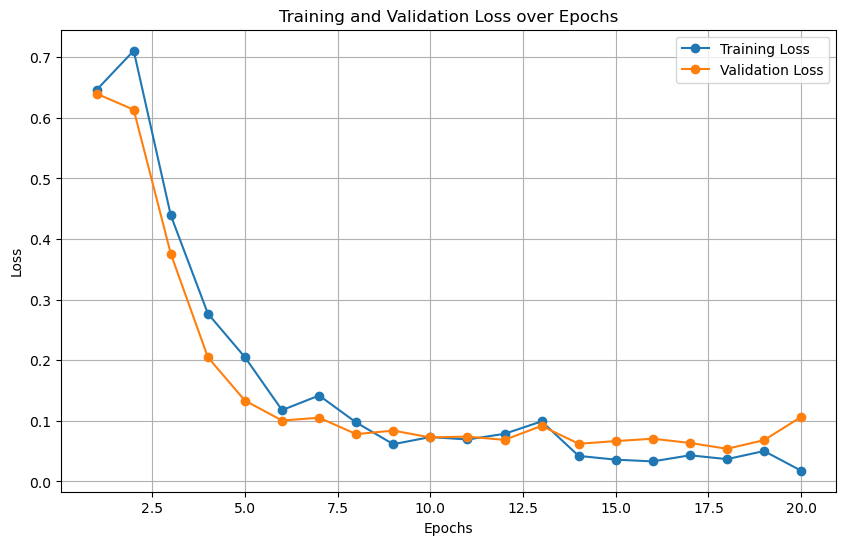

Model saved as model_2024-12-04_09-48-51.pth


C:\Users\swaru\AppData\Local\Temp\ipykernel_17036\2178082847.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_features = torch.load("mbert_features_test.pt")
C:\Use

Average Test Loss: 1.0074
Overall Accuracy: 0.7733
Overall Precision: 0.8152
Overall Recall: 0.8260
Overall F1 Score: 0.8206


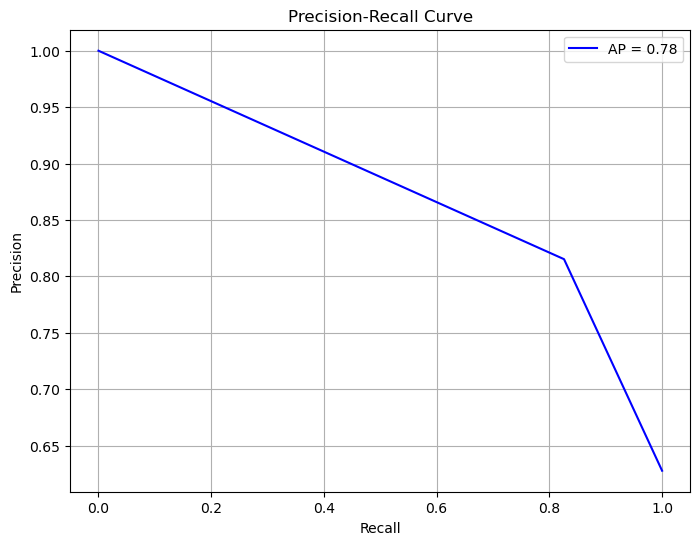

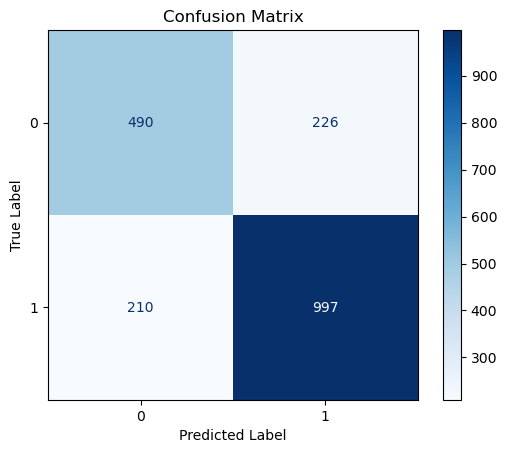

Class 0 (Fake News): Precision=0.70, Recall=0.68, F1 Score=0.69
Class 1 (Real News): Precision=0.82, Recall=0.83, F1 Score=0.82


In [19]:
#provide good result for mBert

params = {

    'text_no_hidden_layer':2,
    'text_hidden_neurons':768,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':2,
    'vis_hidden_neurons':2742,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':7,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
}

model=training(params,train_ratio=0.8,batch_size=256,lr=0.0009,weight_decay=0.00001,num_epochs=20)
testing(model)